<a href="https://colab.research.google.com/github/shehanp-dev/surface-crack-detection-cnn/blob/main/EN3150_Assignment_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EN3150 Assignment 03: Simple convolutional neural network to perform classification.

# Part 1:CNN for image classification.

# Task 1: Setting up the environment.


In [ ]:
# 1.1:Installing and importing required libraries.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
import seaborn as sns
import pathlib
import os

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Task 2: Preparing the dataset.

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: navodyahettigoda
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection


100%|██████████| 233M/233M [00:00<00:00, 953MB/s] 



Total images: 40000
Classes: ['Negative', 'Positive']
Negative: 20000 images
Positive: 20000 images


<Figure size 1200x800 with 0 Axes>

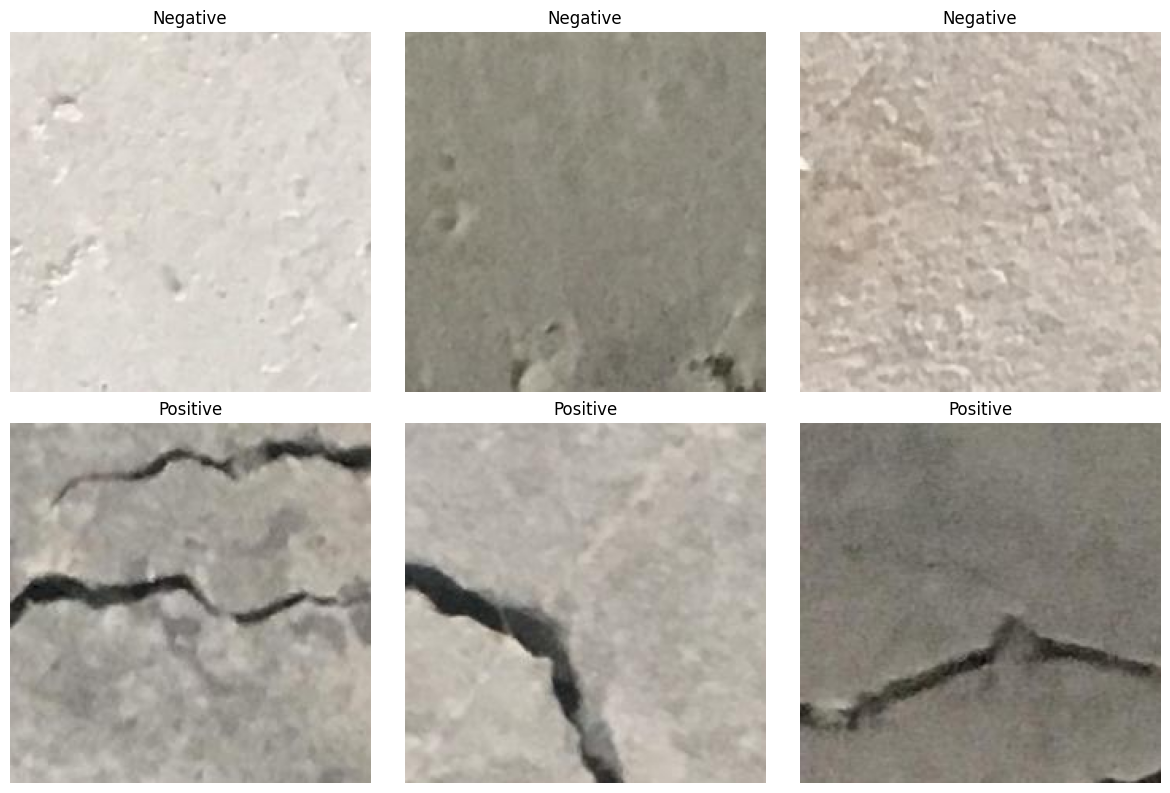

In [ ]:
# Installing opendatasets:This library is used to download datasets from Kaggle.
!pip install opendatasets
# 2.1:Installing and importing required libraries for downloading process.
import opendatasets as od
import pathlib

#2.2: Downloading the dataset (if not already downloaded).
od.download("https://www.kaggle.com/datasets/arunrk7/surface-crack-detection")

#2.3:Setting the data directory path to the downloaded folder.
data_dir = pathlib.Path('surface-crack-detection')

#2.4:Exploring the dataset.
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(f"Total images: {image_count}")

#2.5:Getting the class names.
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f"Classes: {class_names}")

#2.6:Counting images per class.
for class_name in class_names:
    class_path = data_dir / class_name
    class_count = len(list(class_path.glob('*.jpg'))) + len(list(class_path.glob('*.png')))
    print(f"{class_name}: {class_count} images")

#2.7:Visualizing sample images.
    plt.figure(figsize=(12, 8))
for idx, class_name in enumerate(class_names):
    class_path = data_dir / class_name
    images = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))

    for i in range(3):
        plt.subplot(len(class_names), 3, idx * 3 + i + 1)
        img = plt.imread(str(images[i]))
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
plt.tight_layout()
plt.show()

#Kaggle key:5c4ecbc7e18fddbcf72ebb32729256f4

#Task 3: Data splitting and loading.

In [ ]:
#3.1:Defining parameters.
batch_size = 32
img_height = 128  # Standard size for transfer learning.
img_width = 128
seed = 123

#3.2:Creating training dataset (70%).
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # 30% for validation + test.
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

#3.3:Creating validation and test datasets (15% each).
# First, getting the remaining 30%.
temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

#3.4:Splitting the 30% into two equal parts (15% validation, 15% test).
temp_size = tf.data.experimental.cardinality(temp_ds).numpy()
val_size = temp_size // 2

val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

print(f"Training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

#3.5:Configuring dataset for performance.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 40000 files belonging to 2 classes.
Using 28000 files for training.
Class names: ['Negative', 'Positive']
Number of classes: 2
Found 40000 files belonging to 2 classes.
Using 12000 files for validation.
Training batches: 875
Validation batches: 187
Test batches: 188


# Building the CNN model.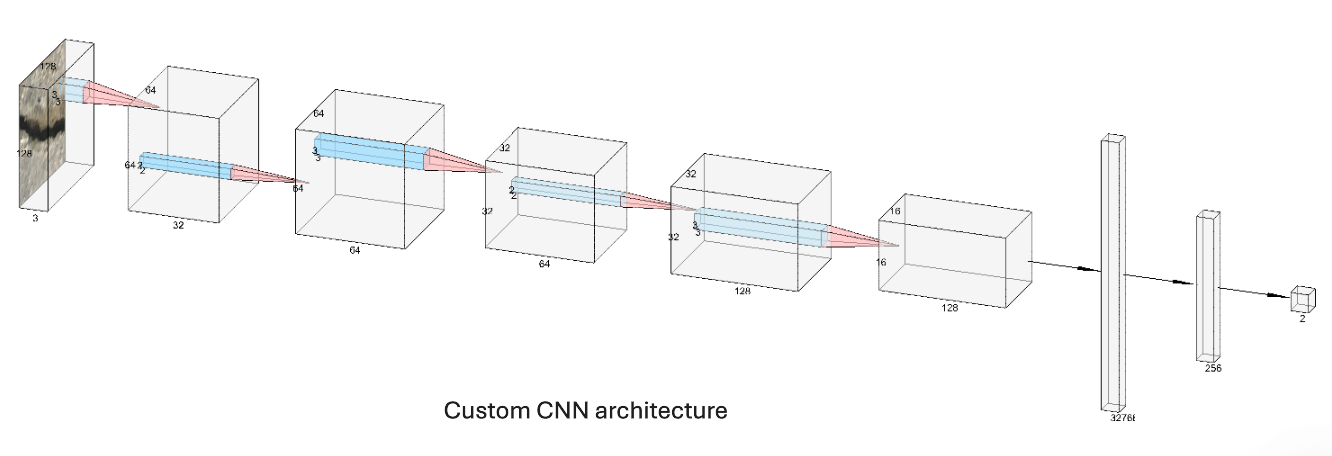





In [ ]:
# 4.1: Defining Data Augmentation.
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# 4.2: Building custom CNN architecture.
def create_custom_cnn(input_shape=(img_height, img_width, 3), num_classes=2):
    model = Sequential([
        # Data augmentation (active only during training).
        data_augmentation,

        # Normalization.
        layers.Rescaling(1./255, input_shape=input_shape),

        # First Convolutional Block.
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),

        # Second Convolutional Block.
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),

        # Third Convolutional Block.
        layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv3'),
        layers.MaxPooling2D((2, 2), name='pool3'),

        # Flatten and Dense Layers.
        layers.Flatten(name='flatten'),
        layers.Dense(256, activation='relu', name='fc1'),
        layers.Dropout(0.5, name='dropout'),

        # Output Layer
        layers.Dense(num_classes, activation='softmax', name='output')
    ])

    return model

# Creating the model.
custom_model = create_custom_cnn(num_classes=num_classes)
custom_model.build(input_shape=(None, img_height, img_width, 3))

# Showing the summary
custom_model.summary()

# 4.3: Visualizing Model rchitecture
tf.keras.utils.plot_model(
    custom_model,
    to_file='custom_cnn_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=96
)

print("Model architecture diagram saved as 'custom_cnn_architecture.png'")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,626 (32.36 MB)

 Trainable params: 8,482,626 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

Model architecture diagram saved as 'custom_cnn_architecture.png'


#Task 7: Training with different opptimizers

TRAINING SESSION 1: ADAM OPTIMIZER

Creating Custom CNN with Adam optimizer...

Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,626 (32.36 MB)

 Trainable params: 8,482,626 (32.36 MB)

 Non-trainable params: 0 (0.00 B)


STARTING TRAINING...
Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 67s 32ms/step - accuracy: 0.9247 - loss: 0.1938 - val_accuracy: 0.9886 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.9858 - loss: 0.0484 - val_accuracy: 0.9828 - val_loss: 0.0524 - learning_rate: 0.0010
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.9865 - loss: 0.0450 - val_accuracy: 0.9942 - val_loss: 0.0190 - learning_rate: 0.0010
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.9915 - loss: 0.0285 - val_accuracy: 0.9945 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.9888 - loss: 0.0370 - val_accuracy: 0.9928 - val_loss: 0.0199 - learning_rate: 0.0010
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.9918 - loss: 0.0310 - val_accuracy: 0.9850 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step 


SAVING MODEL...
Model saved as 'custom_cnn_adam.h5'
✓ Training history saved as 'history_adam.csv'


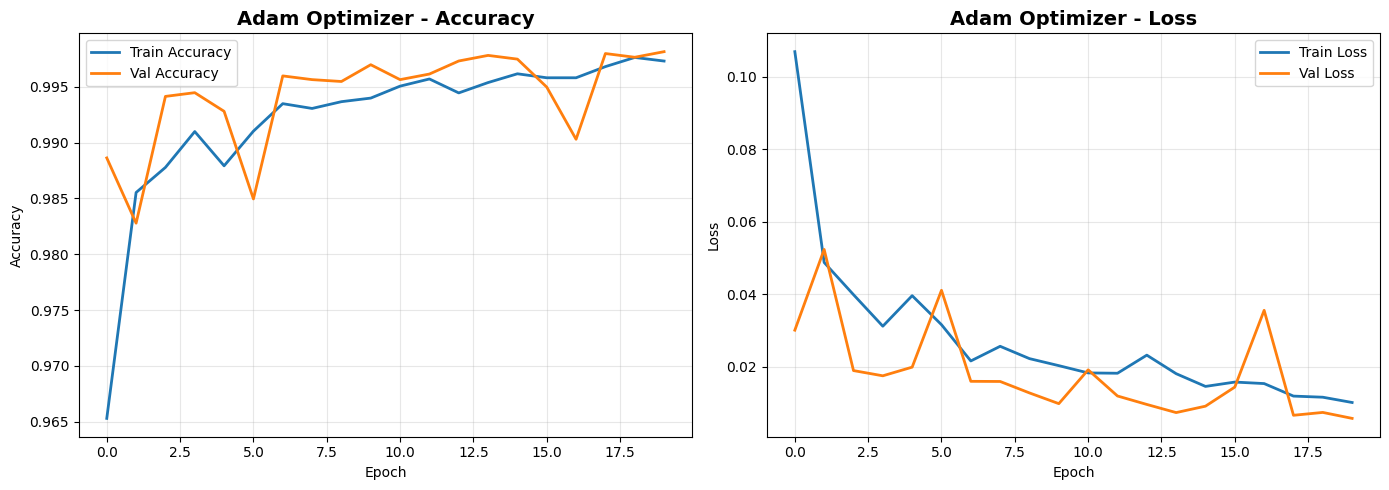

✓ Training plot saved as 'training_adam.png'

TRAINING COMPLETE - ADAM OPTIMIZER
Final Training Accuracy: 0.9973
Final Validation Accuracy: 0.9982
Best Validation Accuracy: 0.9982
Final Training Loss: 0.0102
Final Validation Loss: 0.0058

Clearing memory...
Memory cleared

 IMPORTANT: You can now move to the next training session (SGD)


In [ ]:
#Training Session 1:ADAM Optimizer.
import gc
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

print("="*80)
print("TRAINING SESSION 1: ADAM OPTIMIZER")
print("="*80)

# Defining parameters.
learning_rate = 0.001
epochs = 20

# Callbacks.
callbacks_adam = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    )
]

# Creating the model.
print("\nCreating Custom CNN with Adam optimizer...")
custom_model_adam = create_custom_cnn(num_classes=num_classes)
custom_model_adam.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
custom_model_adam.summary()

# Training.
print("\n" + "="*80)
print("STARTING TRAINING...")
print("="*80)

history_adam = custom_model_adam.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_adam,
    verbose=1
)

# Saving the model.
print("\n" + "="*80)
print("SAVING MODEL...")
print("="*80)

custom_model_adam.save('custom_cnn_adam.h5')
print("Model saved as 'custom_cnn_adam.h5'")

# Saving training history as CSV.
import pandas as pd

history_df = pd.DataFrame({
    'epoch': range(1, len(history_adam.history['accuracy']) + 1),
    'train_accuracy': history_adam.history['accuracy'],
    'val_accuracy': history_adam.history['val_accuracy'],
    'train_loss': history_adam.history['loss'],
    'val_loss': history_adam.history['val_loss']
})

history_df.to_csv('history_adam.csv', index=False)
print("✓ Training history saved as 'history_adam.csv'")

# Plotting training curves.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_adam.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_adam.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Adam Optimizer - Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_adam.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_adam.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Adam Optimizer - Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_adam.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training plot saved as 'training_adam.png'")

# Printing the summary.
print("\n" + "="*80)
print("TRAINING COMPLETE - ADAM OPTIMIZER")
print("="*80)
print(f"Final Training Accuracy: {history_adam.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_adam.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history_adam.history['val_accuracy']):.4f}")
print(f"Final Training Loss: {history_adam.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_adam.history['val_loss'][-1]:.4f}")
print("="*80)

# Download files (optional - uncomment if needed)
# from google.colab import files
# files.download('custom_cnn_adam.h5')
# files.download('history_adam.csv')
# files.download('training_adam.png')

# Clearing memory.
print("\nClearing memory...")
del custom_model_adam
K.clear_session()
gc.collect()
print("Memory cleared")
print("\n IMPORTANT: You can now move to the next training session (SGD)")

TRAINING SESSION 2: STANDARD SGD OPTIMIZER

Creating Custom CNN with SGD optimizer...

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,626 (32.36 MB)

 Trainable params: 8,482,626 (32.36 MB)

 Non-trainable params: 0 (0.00 B)


STARTING TRAINING...
Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.5593 - loss: 0.6849 - val_accuracy: 0.4948 - val_loss: 0.6637 - learning_rate: 0.0010
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.7254 - loss: 0.6314 - val_accuracy: 0.8941 - val_loss: 0.4996 - learning_rate: 0.0010
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.8388 - loss: 0.4645 - val_accuracy: 0.9345 - val_loss: 0.2602 - learning_rate: 0.0010
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9228 - loss: 0.2512 - val_accuracy: 0.9372 - val_loss: 0.1650 - learning_rate: 0.0010
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9478 - loss: 0.1630 - val_accuracy: 0.9539 - val_loss: 0.1268 - learning_rate: 0.0010
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9567 - loss: 0.1337 - val_accuracy: 0.9721 - val_loss: 0.1089 - learning_rate: 0.0010
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step 


SAVING MODEL...
Model saved as 'custom_cnn_sgd.h5'
Training history saved as 'history_sgd.csv'


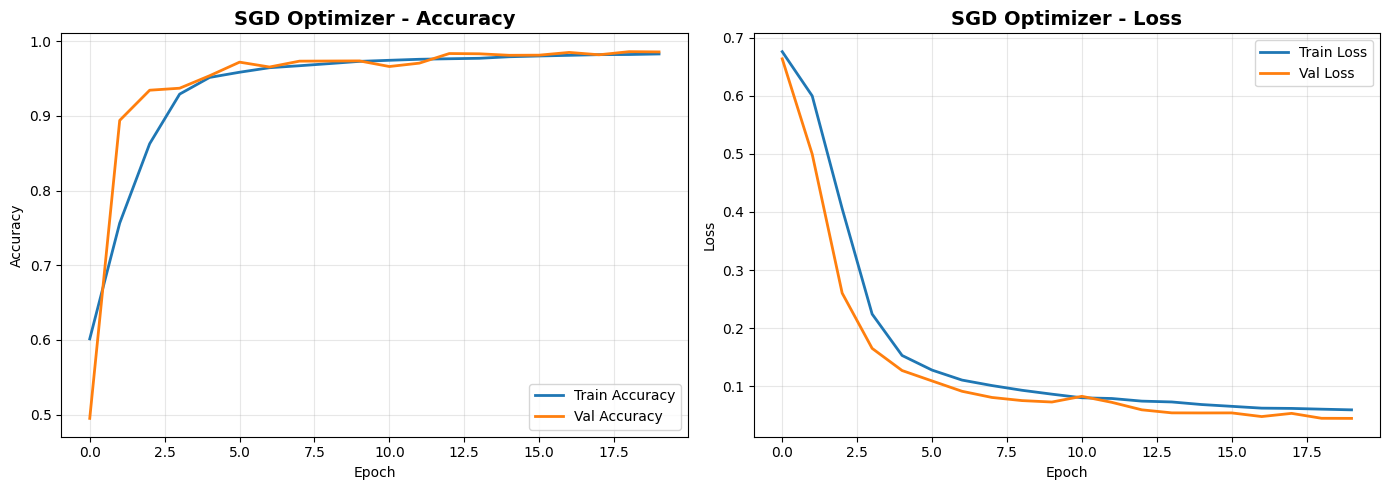

Training plot saved as 'training_sgd.png'

TRAINING COMPLETE - STANDARD SGD OPTIMIZER
Final Training Accuracy: 0.9831
Final Validation Accuracy: 0.9858
Best Validation Accuracy: 0.9861
Final Training Loss: 0.0591
Final Validation Loss: 0.0444

Clearing memory...
Memory cleared

 IMPORTANT: You can now move to the next training session (SGD + Momentum)


In [ ]:
#Training Session 2:Standard SGD Optimizer.
import gc
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD

print("="*80)
print("TRAINING SESSION 2: STANDARD SGD OPTIMIZER")
print("="*80)

# Defining parameters.
learning_rate = 0.001
epochs = 20

# Callbacks.
callbacks_sgd = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    )
]

# Creating the model.
print("\nCreating Custom CNN with SGD optimizer...")
custom_model_sgd = create_custom_cnn(num_classes=num_classes)
custom_model_sgd.compile(
    optimizer=SGD(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
custom_model_sgd.summary()

# Train
print("\n" + "="*80)
print("STARTING TRAINING...")
print("="*80)

history_sgd = custom_model_sgd.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_sgd,
    verbose=1
)

# Saving the model.
print("\n" + "="*80)
print("SAVING MODEL...")
print("="*80)

custom_model_sgd.save('custom_cnn_sgd.h5')
print("Model saved as 'custom_cnn_sgd.h5'")

# Saving training history as CSV.
import pandas as pd

history_df = pd.DataFrame({
    'epoch': range(1, len(history_sgd.history['accuracy']) + 1),
    'train_accuracy': history_sgd.history['accuracy'],
    'val_accuracy': history_sgd.history['val_accuracy'],
    'train_loss': history_sgd.history['loss'],
    'val_loss': history_sgd.history['val_loss']
})

history_df.to_csv('history_sgd.csv', index=False)
print("Training history saved as 'history_sgd.csv'")

# Plotting training curves.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_sgd.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_sgd.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('SGD Optimizer - Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_sgd.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_sgd.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('SGD Optimizer - Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_sgd.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training plot saved as 'training_sgd.png'")

# Printing summary.
print("\n" + "="*80)
print("TRAINING COMPLETE - STANDARD SGD OPTIMIZER")
print("="*80)
print(f"Final Training Accuracy: {history_sgd.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_sgd.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history_sgd.history['val_accuracy']):.4f}")
print(f"Final Training Loss: {history_sgd.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_sgd.history['val_loss'][-1]:.4f}")
print("="*80)

# Download files (optional - uncomment if needed)
# from google.colab import files
# files .download('custom_cnn_sgd.h5')
# files.download('history_sgd.csv')
# files.download('training_sgd.png')

# Clearing memory.
print("\nClearing memory...")
del custom_model_sgd
K.clear_session()
gc.collect()
print("Memory cleared")
print("\n IMPORTANT: You can now move to the next training session (SGD + Momentum)")

In [ ]:
#Training Session 3:SGD with Momentum.
import gc
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD

print("="*80)
print("TRAINING SESSION 3: SGD WITH MOMENTUM")
print("="*80)

# Defining parameters.
learning_rate = 0.001
momentum_value = 0.9
epochs = 20

# Callbacks.
callbacks_momentum = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    )
]

# Creating the model.
print(f"\nCreating Custom CNN with SGD optimizer (momentum={momentum_value})...")
custom_model_sgd_momentum = create_custom_cnn(num_classes=num_classes)
custom_model_sgd_momentum.compile(
    optimizer=SGD(learning_rate=learning_rate, momentum=momentum_value),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
custom_model_sgd_momentum.summary()

# Train
print("\n" + "="*80)
print("STARTING TRAINING...")
print("="*80)

history_sgd_momentum = custom_model_sgd_momentum.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_momentum,
    verbose=1
)

# Saving the model.
print("\n" + "="*80)
print("SAVING MODEL...")
print("="*80)

custom_model_sgd_momentum.save('custom_cnn_sgd_momentum.h5')
print("Model saved as 'custom_cnn_sgd_momentum.h5'")

# Saving training history as CSV.
import pandas as pd

history_df = pd.DataFrame({
    'epoch': range(1, len(history_sgd_momentum.history['accuracy']) + 1),
    'train_accuracy': history_sgd_momentum.history['accuracy'],
    'val_accuracy': history_sgd_momentum.history['val_accuracy'],
    'train_loss': history_sgd_momentum.history['loss'],
    'val_loss': history_sgd_momentum.history['val_loss']
})

history_df.to_csv('history_sgd_momentum.csv', index=False)
print("Training history saved as 'history_sgd_momentum.csv'")

# Plotting training curves.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_sgd_momentum.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_sgd_momentum.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('SGD + Momentum - Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_sgd_momentum.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_sgd_momentum.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('SGD + Momentum - Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_sgd_momentum.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training plot saved as 'training_sgd_momentum.png'")

# Printing summary.
print("\n" + "="*80)
print("TRAINING COMPLETE - SGD WITH MOMENTUM")
print("="*80)
print(f"Final Training Accuracy: {history_sgd_momentum.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_sgd_momentum.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history_sgd_momentum.history['val_accuracy']):.4f}")
print(f"Final Training Loss: {history_sgd_momentum.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_sgd_momentum.history['val_loss'][-1]:.4f}")
print("="*80)

# Download files (optional - uncomment if needed)
# from google.colab import files
# files.download('custom_cnn_sgd_momentum.h5')
# files.download('history_sgd_momentum.csv')
# files.download('training_sgd_momentum.png')

# Clearing memory.
print("\nClearing memory...")
del custom_model_sgd_momentum
K.clear_session()
gc.collect()
print("Memory cleared")
print("\n ALL OPTIMIZER TRAINING SESSIONS COMPLETE!")

LOADING AND COMPARING ALL TRAINING HISTORIES


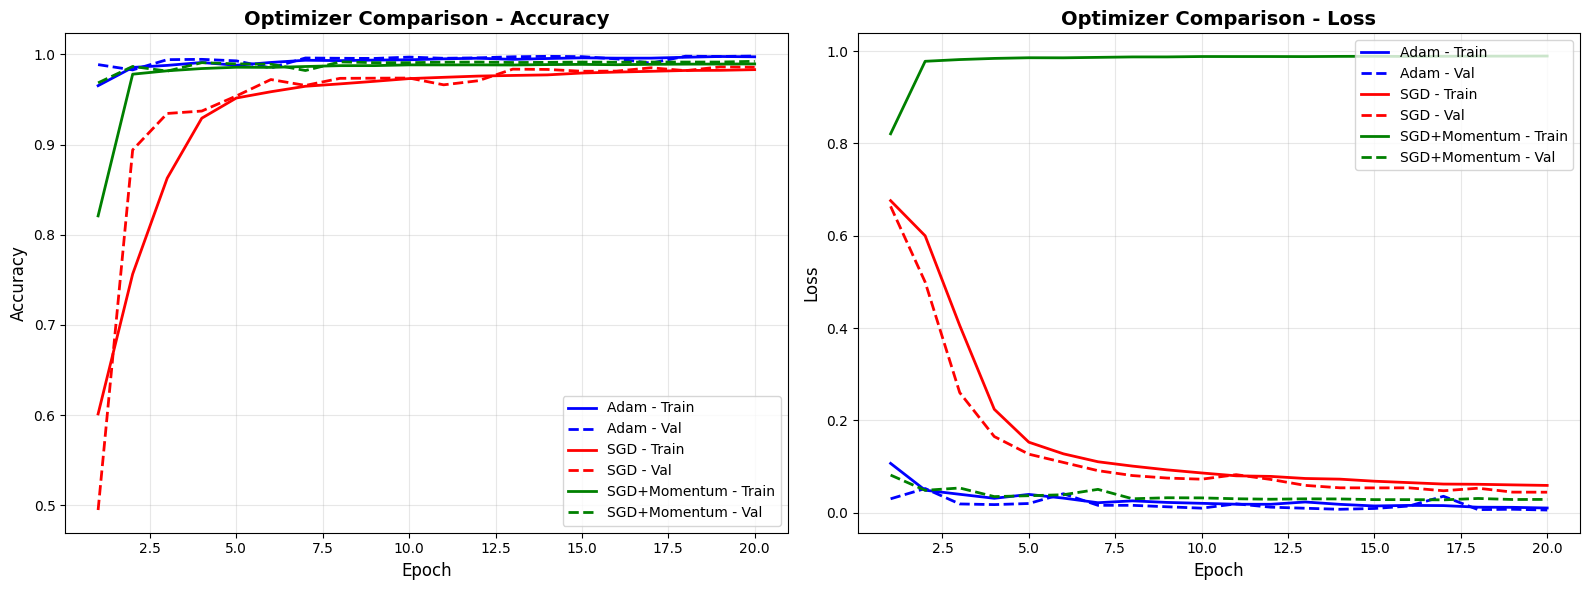

Comparison plot saved as 'optimizer_comparison.png'

OPTIMIZER COMPARISON SUMMARY
     Optimizer  Final Train Acc  Final Val Acc  Best Val Acc  Final Train Loss  Final Val Loss
          Adam         0.997321       0.998162      0.998162          0.010195        0.005817
           SGD         0.983071       0.985795      0.986130          0.059122        0.028780
SGD + Momentum         0.989429       0.992313      0.992313          0.037705        0.028780

 Comparison table saved as 'optimizer_comparison.csv'

MOMENTUM IMPACT ANALYSIS
SGD Final Val Accuracy: 0.9858
SGD+Momentum Final Val Accuracy: 0.9923
Improvement: 0.66%

 ALL COMPARISONS COMPLETE!


In [ ]:
#Comparison of all optimizers.
import pandas as pd
import matplotlib.pyplot as plt

print("="*80)
print("LOADING AND COMPARING ALL TRAINING HISTORIES")
print("="*80)

# Loading all saved histories.
history_adam_df = pd.read_csv('history_adam.csv')
history_sgd_df = pd.read_csv('history_sgd.csv')
history_sgd_momentum_df = pd.read_csv('history_sgd_momentum.csv')

# Creating comparison plot.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy comparison.
axes[0].plot(history_adam_df['epoch'], history_adam_df['train_accuracy'],
             'b-', label='Adam - Train', linewidth=2)
axes[0].plot(history_adam_df['epoch'], history_adam_df['val_accuracy'],
             'b--', label='Adam - Val', linewidth=2)
axes[0].plot(history_sgd_df['epoch'], history_sgd_df['train_accuracy'],
             'r-', label='SGD - Train', linewidth=2)
axes[0].plot(history_sgd_df['epoch'], history_sgd_df['val_accuracy'],
             'r--', label='SGD - Val', linewidth=2)
axes[0].plot(history_sgd_momentum_df['epoch'], history_sgd_momentum_df['train_accuracy'],
             'g-', label='SGD+Momentum - Train', linewidth=2)
axes[0].plot(history_sgd_momentum_df['epoch'], history_sgd_momentum_df['val_accuracy'],
             'g--', label='SGD+Momentum - Val', linewidth=2)
axes[0].set_title('Optimizer Comparison - Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss comparison.
axes[1].plot(history_adam_df['epoch'], history_adam_df['train_loss'],
             'b-', label='Adam - Train', linewidth=2)
axes[1].plot(history_adam_df['epoch'], history_adam_df['val_loss'],
             'b--', label='Adam - Val', linewidth=2)
axes[1].plot(history_sgd_df['epoch'], history_sgd_df['train_loss'],
             'r-', label='SGD - Train', linewidth=2)
axes[1].plot(history_sgd_df['epoch'], history_sgd_df['val_loss'],
             'r--', label='SGD - Val', linewidth=2)
axes[1].plot(history_sgd_momentum_df['epoch'], history_sgd_momentum_df['train_accuracy'],
             'g-', label='SGD+Momentum - Train', linewidth=2)
axes[1].plot(history_sgd_momentum_df['epoch'], history_sgd_momentum_df['val_loss'],
             'g--', label='SGD+Momentum - Val', linewidth=2)
axes[1].set_title('Optimizer Comparison - Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('optimizer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparison plot saved as 'optimizer_comparison.png'")

# Creating comparison table.
comparison_data = {
    'Optimizer': ['Adam', 'SGD', 'SGD + Momentum'],
    'Final Train Acc': [
        history_adam_df['train_accuracy'].iloc[-1],
        history_sgd_df['train_accuracy'].iloc[-1],
        history_sgd_momentum_df['train_accuracy'].iloc[-1]
    ],
    'Final Val Acc': [
        history_adam_df['val_accuracy'].iloc[-1],
        history_sgd_df['val_accuracy'].iloc[-1],
        history_sgd_momentum_df['val_accuracy'].iloc[-1]
    ],
    'Best Val Acc': [
        history_adam_df['val_accuracy'].max(),
        history_sgd_df['val_accuracy'].max(),
        history_sgd_momentum_df['val_accuracy'].max()
    ],
    'Final Train Loss': [
        history_adam_df['train_loss'].iloc[-1],
        history_sgd_df['train_loss'].iloc[-1],
        history_sgd_momentum_df['train_loss'].iloc[-1]
    ],
    'Final Val Loss': [
        history_adam_df['val_loss'].iloc[-1],
        history_sgd_momentum_df['val_loss'].iloc[-1],
        history_sgd_momentum_df['val_loss'].iloc[-1]
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("OPTIMIZER COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Saving comparison table.
comparison_df.to_csv('optimizer_comparison.csv', index=False)
print("\n Comparison table saved as 'optimizer_comparison.csv'")

# Momentum impact analysis.
sgd_val_acc = history_sgd_df['val_accuracy'].iloc[-1]
momentum_val_acc = history_sgd_momentum_df['val_accuracy'].iloc[-1]
improvement = ((momentum_val_acc - sgd_val_acc) / sgd_val_acc) * 100

print("\n" + "="*80)
print("MOMENTUM IMPACT ANALYSIS")
print("="*80)
print(f"SGD Final Val Accuracy: {sgd_val_acc:.4f}")
print(f"SGD+Momentum Final Val Accuracy: {momentum_val_acc:.4f}")
print(f"Improvement: {improvement:.2f}%")
print("="*80)

print("\n ALL COMPARISONS COMPLETE!")

In [ ]:
# Evaluating best model on test set.
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

print("="*80)
print("EVALUATING BEST MODEL (ADAM) ON TEST SET")
print("="*80)

# Loading the best model.
from tensorflow.keras.models import load_model

print("\nLoading trained model...")
best_model = load_model('custom_cnn_adam.h5')
print("Model loaded successfully")

# Evaluating on test set.
print("\nEvaluating on test dataset...")
test_loss, test_accuracy = best_model.evaluate(test_ds, verbose=1)

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("="*80)

# Getting predictions.
print("\nGenerating predictions...")
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = best_model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix.
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Custom CNN (Adam)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_adam.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved as 'confusion_matrix_adam.png'")

# Classification Report.
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
report = classification_report(y_true, y_pred,
                               target_names=class_names,
                               digits=4)
print(report)

# Calculating metrics.
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print("="*80)
print("WEIGHTED AVERAGE METRICS")
print("="*80)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("="*80)

# Saving results.
results_summary = f"""
TEST SET EVALUATION RESULTS
============================

Model: Custom CNN with Adam Optimizer
Test Accuracy: {test_accuracy:.4f}
Test Loss: {test_loss:.4f}
Weighted Precision: {precision:.4f}
Weighted Recall: {recall:.4f}

Confusion Matrix:
{cm}

Classification Report:
{report}
"""

with open('test_results_adam.txt', 'w') as f:
    f.write(results_summary)

print("\n Results saved to 'test_results_adam.txt'")
print("\n EVALUATION COMPLETE!")

#Task 12:Evaluating the Model

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9975 - loss: 0.0062

Test Accuracy: 0.9982
Test Loss: 0.0064


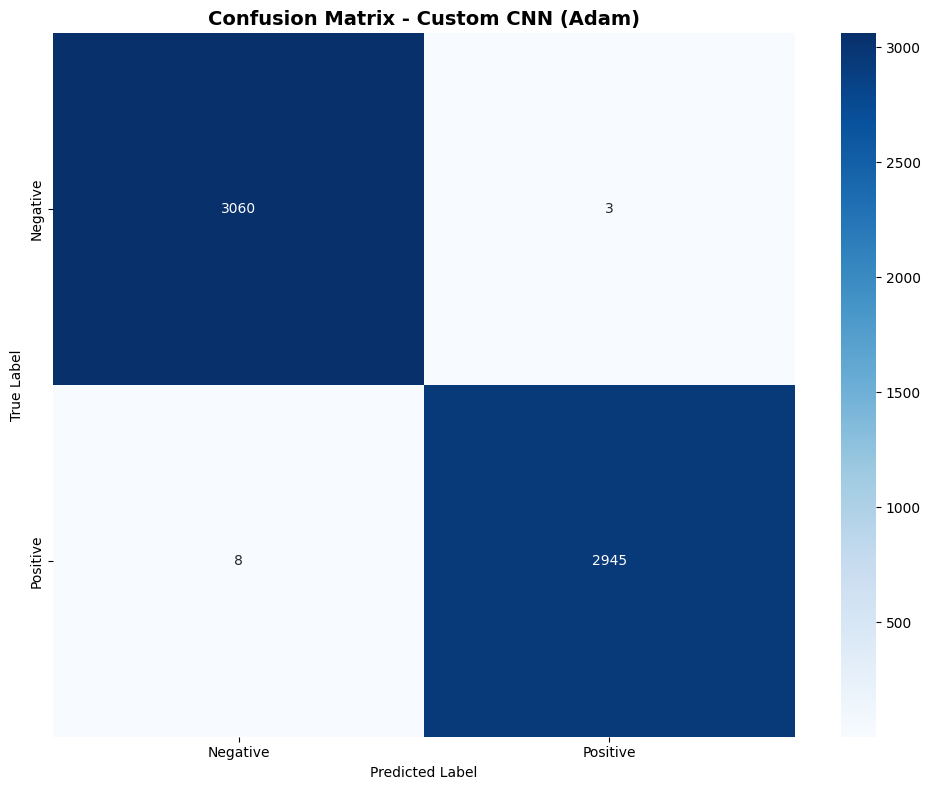


CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative     0.9974    0.9990    0.9982      3063
    Positive     0.9990    0.9973    0.9981      2953

    accuracy                         0.9982      6016
   macro avg     0.9982    0.9982    0.9982      6016
weighted avg     0.9982    0.9982    0.9982      6016


Weighted Precision: 0.9982
Weighted Recall: 0.9982


In [ ]:
# Loading best model.
from tensorflow.keras.models import load_model

best_model = load_model('custom_cnn_adam.h5')

# Evaluating.
test_loss, test_accuracy = best_model.evaluate(test_ds, verbose=1)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Getting predictions.
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = best_model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix.
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Custom CNN (Adam)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# Classification Report.
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Metrics.
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"\nWeighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print("="*80)

# Part 2:Comparing the network with state-of-the-art networks

#Loading the pre-trained model and fine-tune it for surface crack dataset.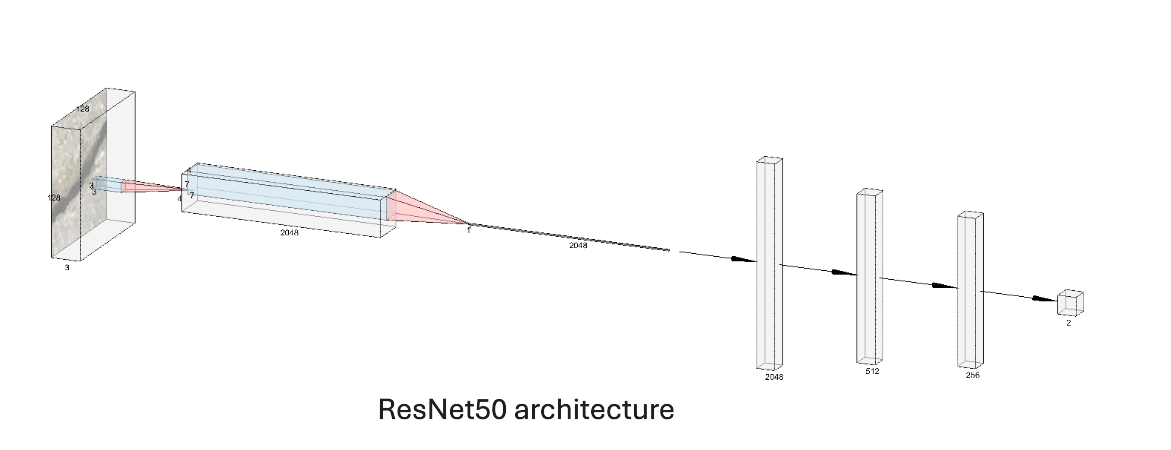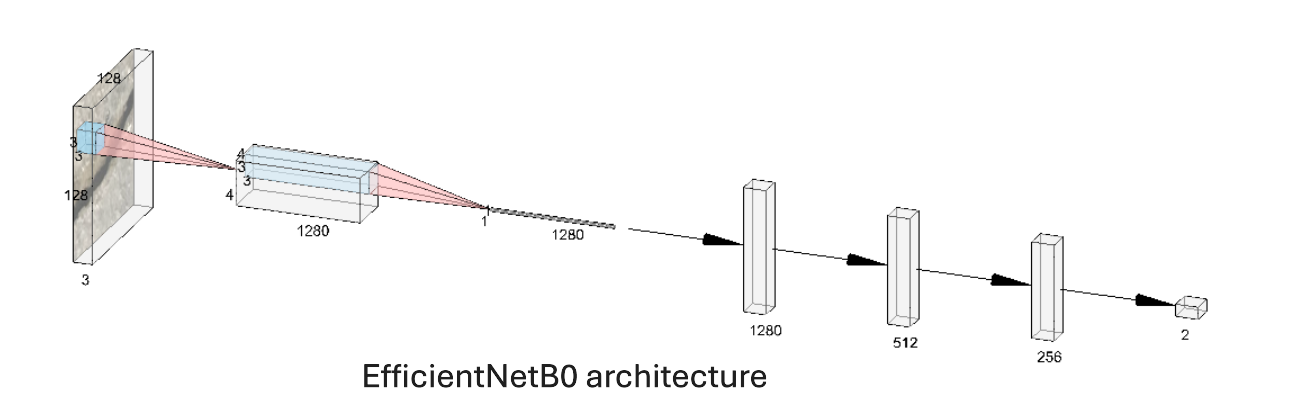

In [ ]:
#14.1:Loading pre-trained models.
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# 14.2:Creating ResNet50 Transfer Learning model.
def create_transfer_model_resnet(input_shape=(img_height, img_width, 3), num_classes=2):
    """
    Create transfer learning model using ResNet50
    """
    # Loading pre-trained ResNet50 (without top classification layer).
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freezing base model layers initially.
    base_model.trainable = False

    # Adding custom classification head.
    model = Sequential([
        data_augmentation,
        layers.Rescaling(1./127.5, offset=-1),  # ResNet preprocessing.
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base_model

resnet_model, resnet_base = create_transfer_model_resnet(num_classes=num_classes)
resnet_model.summary()

# 14.3:Creating EfficientNetB0 Transfer Learning Model.
def create_transfer_model_efficientnet(input_shape=(img_height, img_width, 3), num_classes=2):
    """
    Create transfer learning model using EfficientNetB0
    """
    # Loading pre-trained EfficientNetB0.
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freezing base model layers initially.
    base_model.trainable = False

    # Adding custom classification head.
    model = Sequential([
        data_augmentation,
        layers.Rescaling(1./255),  # EfficientNet preprocessing.
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base_model

efficientnet_model, efficientnet_base = create_transfer_model_efficientnet(num_classes=num_classes)
efficientnet_model.summary()

#Task 15:Training the models using the same training and testing data splits as custom CNN model.

TRAINING RESNET50 - FEATURE EXTRACTION ONLY
Base model has 175 layers (all frozen)

Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,776,834 (94.52 MB)

 Trainable params: 1,185,026 (4.52 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING...
Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 67s 65ms/step - accuracy: 0.9545 - loss: 0.1467 - val_accuracy: 0.9886 - val_loss: 0.0338 - learning_rate: 1.0000e-04
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 54s 61ms/step - accuracy: 0.9860 - loss: 0.0484 - val_accuracy: 0.9911 - val_loss: 0.0274 - learning_rate: 1.0000e-04
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.9873 - loss: 0.0426 - val_accuracy: 0.9921 - val_loss: 0.0245 - learning_rate: 1.0000e-04
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 54s 61ms/step - accuracy: 0.9895 - loss: 0.0334 - val_accuracy: 0.9920 - val_loss: 0.0222 - learning_rate: 1.0000e-04
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 53s 61ms/step - accuracy: 0.9897 - loss: 0.0321 - val_accuracy: 0.9931 - val_loss: 0.0208 - learning_rate: 1.0000e-04
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.9909 - loss: 0.0288 - val_accuracy: 0.9940 - val_loss: 0.0194 - learning_rate: 1.0000e-04
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━


✓ ResNet50 model saved as 'resnet50_finetuned.h5'


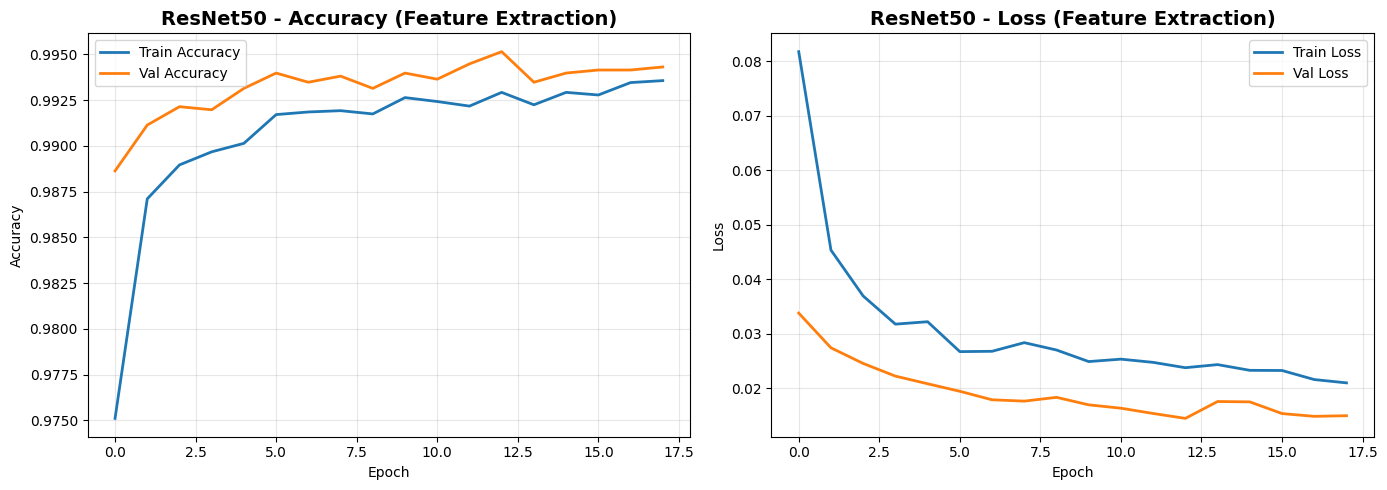


Best Validation Accuracy: 0.9952
Final Validation Accuracy: 0.9943

 ResNet50 training complete!


In [ ]:
#15.1: Transfer Learning with RESNET50
# ============================================================================
# CORRECTED: RESNET50 - FEATURE EXTRACTION ONLY (NO FINE-TUNING)
# ============================================================================

from tensorflow.keras.applications import ResNet50
import gc
from tensorflow.keras import backend as K

print("="*80)
print("TRAINING RESNET50 - FEATURE EXTRACTION ONLY")
print("="*80)

# Create base model
resnet_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# FREEZE ALL layers - no fine-tuning
resnet_base.trainable = False

print(f"Base model has {len(resnet_base.layers)} layers (all frozen)")

# Build complete model
resnet_model = Sequential([
    data_augmentation,
    layers.Rescaling(1./127.5, offset=-1),  # ResNet preprocessing
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),  # Add batch norm for stability
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile with conservative learning rate
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
resnet_model.summary()

# Train with more epochs (since we're not fine-tuning)
print("\n" + "="*80)
print("TRAINING...")
print("="*80)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # More epochs since we're not fine-tuning
    callbacks=callbacks,
    verbose=1
)

# Save model and history
resnet_model.save('resnet50_finetuned.h5')
pd.DataFrame(history_resnet.history).to_csv('history_resnet50.csv', index=False)
print("\n✓ ResNet50 model saved as 'resnet50_finetuned.h5'")

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('ResNet50 - Accuracy (Feature Extraction)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_resnet.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('ResNet50 - Loss (Feature Extraction)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_resnet50.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest Validation Accuracy: {max(history_resnet.history['val_accuracy']):.4f}")
print(f"Final Validation Accuracy: {history_resnet.history['val_accuracy'][-1]:.4f}")
print("="*80)

# Clear memory
del resnet_base
K.clear_session()
gc.collect()

print("\n ResNet50 training complete!")

In [ ]:
#15.2: Transfer Learning with EFFICIENTNETB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, keras
import matplotlib.pyplot as plt
import pandas as pd
import gc
from tensorflow.keras import backend as K

# Re-define variables (in case they're not in memory)
img_height = 128
img_width = 128
# num_classes = 2  # Uncomment if not defined

# Re-define data augmentation (in case it's not in memory)
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

print("="*80)
print("TRAINING EFFICIENTNETB0 - FEATURE EXTRACTION ONLY")
print("="*80)

# Creating base model
efficientnet_base = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

# Freezing all layers - no fine-tuning
efficientnet_base.trainable = False

print(f"Base model has {len(efficientnet_base.layers)} layers (all frozen)")

# Building complete model
efficientnet_model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),  # EfficientNet preprocessing
    efficientnet_base,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compiling with conservative learning rate
efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
efficientnet_model.summary()

# Training
print("\n" + "="*80)
print("TRAINING...")
print("="*80)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

history_efficientnet = efficientnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

# Saving the model and history
efficientnet_model.save('efficientnet_finetuned.h5')
pd.DataFrame(history_efficientnet.history).to_csv('history_efficientnet.csv', index=False)
print("\n✓ EfficientNetB0 model saved as 'efficientnet_finetuned.h5'")

# Plotting the training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_efficientnet.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('EfficientNetB0 - Accuracy (Feature Extraction)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_efficientnet.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('EfficientNetB0 - Loss (Feature Extraction)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_efficientnet.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest Validation Accuracy: {max(history_efficientnet.history['val_accuracy']):.4f}")
print(f"Final Validation Accuracy: {history_efficientnet.history['val_accuracy'][-1]:.4f}")
print("="*80)

# Clearing memory
del efficientnet_base
K.clear_session()
gc.collect()

print("\n✓ EfficientNetB0 training complete!")

# Task 18:Comparing the custom CNN model with abovefine-tuned state-of-the-art models.

In [ ]:
#18.1:Evaluating and comparing all models.

print("\n" + "="*80)
print("TASK 17: EVALUATING TRANSFER LEARNING MODELS")
print("="*80)

# Loading the best model if not in memory.
try:
    best_model_adam = load_model('custom_cnn_adam.h5')
except:
    best_model_adam = custom_model_adam

# Evaluating ResNet50.
print("\nEvaluating ResNet50...")
test_loss_resnet, test_accuracy_resnet = resnet_model.evaluate(test_ds, verbose=0)

y_true_resnet = []
y_pred_resnet = []

for images, labels in test_ds:
    predictions = resnet_model.predict(images, verbose=0)
    y_true_resnet.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_resnet.extend(np.argmax(predictions, axis=1))

y_true_resnet = np.array(y_true_resnet)
y_pred_resnet = np.array(y_pred_resnet)

precision_resnet = precision_score(y_true_resnet, y_pred_resnet, average='weighted')
recall_resnet = recall_score(y_true_resnet, y_pred_resnet, average='weighted')

results_resnet = {
    'test_accuracy': test_accuracy_resnet,
    'test_loss': test_loss_resnet,
    'precision': precision_resnet,
    'recall': recall_resnet,
    'y_true': y_true_resnet,
    'y_pred': y_pred_resnet
}

print(f" ResNet50 Test Accuracy: {test_accuracy_resnet:.4f}")

# Evaluating EfficientNetB0.
print("\nEvaluating EfficientNetB0...")
test_loss_eff, test_accuracy_eff = efficientnet_model.evaluate(test_ds, verbose=0)

y_true_eff = []
y_pred_eff = []

for images, labels in test_ds:
    predictions = efficientnet_model.predict(images, verbose=0)
    y_true_eff.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_eff.extend(np.argmax(predictions, axis=1))

y_true_eff = np.array(y_true_eff)
y_pred_eff = np.array(y_pred_eff)

precision_eff = precision_score(y_true_eff, y_pred_eff, average='weighted')
recall_eff = recall_score(y_true_eff, y_pred_eff, average='weighted')

results_efficientnet = {
    'test_accuracy': test_accuracy_eff,
    'test_loss': test_loss_eff,
    'precision': precision_eff,
    'recall': recall_eff,
    'y_true': y_true_eff,
    'y_pred': y_pred_eff
}

print(f"EfficientNetB0 Test Accuracy: {test_accuracy_eff:.4f}")

# 18.2: Comprehensive Comparison.

print("\n" + "="*80)
print("TASK 18: FINAL MODEL COMPARISON")
print("="*80)

# Loading Custom CNN results.
try:
    custom_acc = results_adam['test_accuracy']
except:
    print("\nEvaluating Custom CNN (Adam)...")
    test_loss_adam, test_accuracy_adam = best_model_adam.evaluate(test_ds, verbose=0)

    y_true_adam = []
    y_pred_adam = []

    for images, labels in test_ds:
        predictions = best_model_adam.predict(images, verbose=0)
        y_true_adam.extend(np.argmax(labels.numpy(), axis=1))
        y_pred_adam.extend(np.argmax(predictions, axis=1))

    y_true_adam = np.array(y_true_adam)
    y_pred_adam = np.array(y_pred_adam)

    precision_adam = precision_score(y_true_adam, y_pred_adam, average='weighted')
    recall_adam = recall_score(y_true_adam, y_pred_adam, average='weighted')

    results_adam = {
        'test_accuracy': test_accuracy_adam,
        'test_loss': test_loss_adam,
        'precision': precision_adam,
        'recall': recall_adam
    }

# Creating comparison dataFrame.
comparison = pd.DataFrame({
    'Model': ['Custom CNN (Adam)', 'ResNet50', 'EfficientNetB0'],
    'Test Accuracy': [
        results_adam['test_accuracy'],
        results_resnet['test_accuracy'],
        results_efficientnet['test_accuracy']
    ],
    'Test Loss': [
        results_adam['test_loss'],
        results_resnet['test_loss'],
        results_efficientnet['test_loss']
    ],
    'Precision': [
        results_adam['precision'],
        results_resnet['precision'],
        results_efficientnet['precision']
    ],
    'Recall': [
        results_adam['recall'],
        results_resnet['recall'],
        results_efficientnet['recall']
    ]
})

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)

# Saving comparison.
comparison.to_csv('final_model_comparison.csv', index=False)

# Visualizing comparison.
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Test Accuracy', 'Test Loss', 'Precision', 'Recall']
colors = ['#2ecc71', '#3498db', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(comparison['Model'], comparison[metric], color=colors)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_ylim([0, max(comparison[metric]) * 1.2])

    # Adding value labels on bars.
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.4f}',
               ha='center', va='bottom', fontweight='bold')

    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculating improvements.
custom_acc = results_adam['test_accuracy']
resnet_acc = results_resnet['test_accuracy']
efficientnet_acc = results_efficientnet['test_accuracy']

best_model_name = 'ResNet50' if resnet_acc > efficientnet_acc else 'EfficientNetB0'
best_acc = max(resnet_acc, efficientnet_acc)
improvement = ((best_acc - custom_acc) / custom_acc) * 100

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"Custom CNN Test Accuracy: {custom_acc:.4f}")
print(f"ResNet50 Test Accuracy: {resnet_acc:.4f}")
print(f"EfficientNetB0 Test Accuracy: {efficientnet_acc:.4f}")
print(f"\nBest Transfer Learning Model: {best_model_name}")
print(f"Improvement over Custom CNN: {improvement:.2f}%")
print("="*80)

print("\n TASK COMPLETE!")